In [1]:
using DataFrames, CSV, JuMP, Gurobi, Metrics, Plots, StatsBase

In [2]:
# load data
train_valid = CSV.read("train_valid.csv", DataFrame)
test = CSV.read("test.csv", DataFrame);

In [3]:
# define target and features
target = "value_eur"
# features = all columns except target
features = setdiff(names(train_valid), target);

function get_features(df)
    # get features from dataframe
    return df[:, features]
end

function get_target(df)
    # get target from dataframe
    return df[:, target]
end

get_target (generic function with 1 method)

## Data pre-processing: fees and release clauses

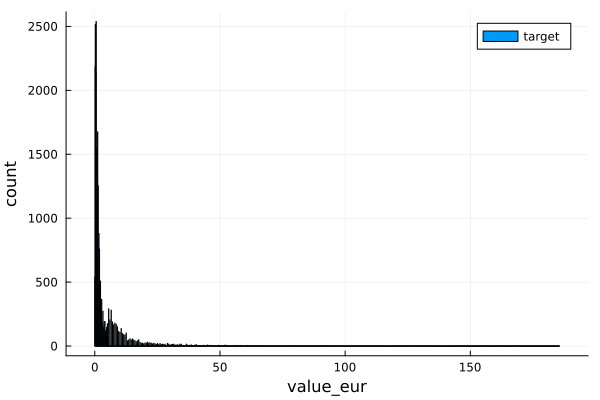

In [4]:
# plot target
histogram(get_target(train_valid), label="target", xlabel="value_eur", ylabel="count")

## Define functions that will be used across models

In [39]:
function compute_results(y_pred, y_true)
    
    # compute the results
    mae = Metrics.mae(y_pred, y_true)
    mse = Metrics.mse(y_pred, y_true)
    rmse = sqrt(mse)
    r2 = Metrics.r2_score(y_pred, y_true)

    # store the results in a DataFrame
    results = DataFrame(
        MAE = [mae],
        MSE = [mse],
        RMSE = [rmse],
        R2 = [r2]
    )

    return results
end

function plot_results(y_pred, y_true)
    
    # plot both distributions
    # set plot dimensions
    plot_size = (800, 400)
    
    histogram(y_pred, label = "pred", color = "red", seriesalpha = 0.5)
    display(histogram!(y_true, label = "test", color = "blue", seriesalpha = 0.5))

    # plot (scatter) the predictions vs the true values
    #display(scatter(y_pred, y_true, label = "pred vs test", xlabel = "pred", ylabel = "test", size = plot_size))
end 

plot_results (generic function with 1 method)

## Holistic regression

In [40]:
function pairwise_correlation(data, rho)

    cor_matrix = cor(Matrix(data))

    # we know that the matrix is symmetrix
    # no need to include the correlation between one variable and itself, of course it is 1
    
    p = size(cor_matrix)[1]

    # list to record the variables with which X[i] is correlated
    correlated = []

    for i = 1:(p-1)     
        for j = (i+1):p
            if abs(cor_matrix[i, j]) > rho
                push!(correlated, (i, j))
            end
        end
    end

    return correlated
end

pairwise_correlation (generic function with 1 method)

In [41]:
function transform_data(data)
    
    n, p = size(data)
    epsilon = 1

    new = []

    for j = 1:p
        push!(new, data[:, j])
        push!(new, sqrt.(abs.(data[:, j])))
        push!(new, log.(abs.(data[:, j]) .+ epsilon))
    end

    return hcat(new...)
end

transform_data (generic function with 1 method)

In [42]:
function HolisticRegression(X, y, lambda, k, rho)

    # define the model
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)
    set_optimizer_attribute(model, "NonConvex", 2)

    # PARAMETERS

    n, p = size(X)

    M = 1000

    # call function pairwise_correlation to define HC(X)
    HC = pairwise_correlation(X, rho)
    # define set Tj, because we want to keep at most one transformation
    print(1)
    T = []
    for j = 1:Int(p/3) # this applies to the original p
        push!(T, X[:, 3*(j-1)+1 : 3*(j-1)+3])
    end

    # VARIABLES

    @variable(model, beta[1:p])
    @variable(model, t)
    @variable(model, r)
    @variable(model, q[1:p])
    @variable(model, z[1:p], binary = true) # binary variable

    # OBJECTIVE FUNCTION

    @objective(model, Min, t + lambda * r)

    # CONSTRAINTS

    @constraint(model, t >= sum((y[i]-sum(X[i,j]*beta[j] for j=1:p))^2 for i=1:n)) # to rewrite objective function
    @constraint(model, r >= sum(q[j] for j=1:p)) # to rewrite objective function
    @constraint(model, [j=1:p], q[j] >= beta[j]) # to rewrite objective function
    @constraint(model, [j=1:p], q[j] >= -beta[j]) # to rewrite objective function

    @constraint(model, [i=1:p], beta[i]<=M*z[i]) # sparsity
    @constraint(model, [i=1:p], beta[i]>=-M*z[i]) # sparsity
    @constraint(model, sum(z[i] for i=1:p) <= k) # sparsity

    # pairwise collinearity
    for (i,j) in HC
        @constraint(model, z[i] + z[j] <= 1)
    end
    
    # nonlinear transformation
    @constraint(model, [j=1:Int(p/3)], sum(z[i] for i = 3*(j-1)+1 : 3*(j-1)+3) <= 1)

    # group sparsity

    # significance

    # multicollinear relations

    # OPTIMIZE

    optimize!(model)

    return objective_value(model), value.(beta)

end

HolisticRegression (generic function with 1 method)

In [48]:
function Holistic_model(train_valid, test)

    p_total = size(transform_data(get_features(train_valid)))[2]

    # initialize best model
    obj, best_beta = HolisticRegression(transform_data(get_features(train_valid)), get_target(train_valid), 0, p_total, 0.5)

    # run HolisticRegression for different values of lambda and k, save lambda and k that give the best results
    for rho in [0.7, 0.9]
        for k in [floor(sqrt(p_total)), floor(p_total)]
            for lambda in [0.1, 0.5]
                println("rho = ", rho, ", k = ", k, ", lambda = ", lambda)
                obj_, beta_ = HolisticRegression(transform_data(get_features(train_valid)), get_target(train_valid), lambda, k, rho)
                if obj_ < obj
                    best_beta = beta_
                end
            end
        end
    end

    # define model with best beta, select features corresponding to non-zero beta
    features_keep_sorted = [i for (i, beta) in enumerate(best_beta) if beta != 0]

    # make predictions using the best model (y = X * beta)
    pred = Matrix(transform_data(get_features(test))[:, features_keep_sorted]) * best_beta[features_keep_sorted]

    # compute results
    results = compute_results(pred, get_target(test))

    # plot results
    plot_results(pred, get_target(test))

    println("Holistic results: ", results)

    # return the best model
    return best_beta
end

Holistic_model (generic function with 1 method)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
1Set parameter NonConvex to value 2
rho = 0.7, k = 13.0, lambda = 0.1
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
1Set parameter NonConvex to value 2
rho = 0.7, k = 13.0, lambda = 0.5
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
1Set parameter NonConvex to value 2
rho = 0.7, k = 180.0, lambda = 0.1
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
1Set parameter NonConvex to value 2
rho = 0.7, k = 180.0, lambda = 0.5
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
1Set parameter NonConvex to value 2
rho = 0.9, k = 13.0, lambda = 0.1
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
1Set parameter NonConvex to value 2
rho = 0.9, k = 13.0, lambda = 0.5
Set parameter Username
Academic 

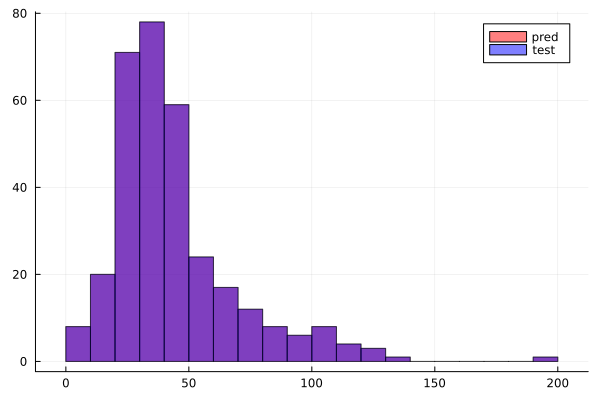

Holistic results: 1×4 DataFrame
 Row │ MAE         MSE          RMSE        R2
     │ Float64     Float64      Float64     Float64
─────┼──────────────────────────────────────────────
   1 │ 1.25448e-9  1.58088e-18  1.25733e-9      1.0


In [49]:
# only use 10% of the data
sample_train_valid = train_valid[1:floor(Int, 0.02 * size(train_valid)[1]), :]
sample_test = test[1:floor(Int, 0.02 * size(test)[1]), :]

HolReg_betas = Holistic_model(sample_train_valid, sample_test)

# save the predictions
features_keep_sorted = [i for (i, beta) in enumerate(HolReg_betas) if beta != 0]
HolReg_pred = Matrix(transform_data(get_features(test))[:, features_keep_sorted]) * HolReg_betas[features_keep_sorted]
CSV.write("HolReg_pred.csv", DataFrame(pred = HolReg_pred));

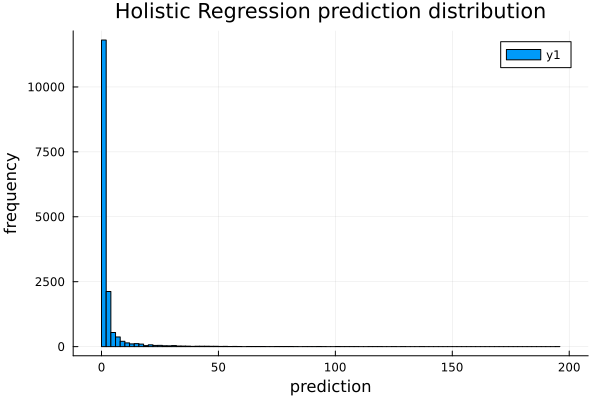

In [50]:
# look at the prediction distribution
histogram(HolReg_pred, bins = 100, xlabel = "prediction", ylabel = "frequency", title = "Holistic Regression prediction distribution")

## ORT (Optimal Regression Trees)

In [8]:
# define ranges for the hyperparameters
max_depth = [3, 4, 5]
minbucket = [2, 5, 10]
;

In [9]:
function ORT_model(train_valid, test)

    # define the model  
    model_oct = IAI.OptimalTreeRegressor(
        random_seed = 1,
        criterion = :mse,
    )

    println("Training model...")

    # define a random grid search
    

    # define the grid
    grid_oct = IAI.GridSearch(
        model_oct,
        max_depth = max_depth,
        minbucket = minbucket,
    )

    println("Fitting model...")

    # fit the model with 5-fold cross validation
    IAI.fit_cv!(grid_oct,
     get_features(train_valid), 
     get_target(train_valid), 
     #train_valid[:, target],
     validation_criterion = :mse, n_folds=5)

    println("Predicting...")

    # get the best model
    pred = IAI.predict(grid_oct, get_features(test))

    println("Computing results...")

    # compute the results
    #compute_results(pred, get_target(test))
    transform_and_results(pred, get_target(test))

    # check the prediction value
    check_prediction_value(pred, get_target(test))

    # return the best model
    return IAI.get_learner(grid_oct)
end

ORT_model (generic function with 1 method)

Training model...
Fitting model...


┌ Warning: This copy of Interpretable AI software is for academic purposes only and not for commercial use.
└ @ nothing nothing:nothing
┌ Warning: Interpretable AI license expires soon: 2022-12-31T00:00:00. If you need to renew, please send us the following machine ID:
│ 7c794baeeadd5d7316f791ae6aac034089a6052cce19227d0af4d9df82ac2e5c
└ @ nothing nothing:nothing


Predicting...
Computing results...


Row,mae,mse,rmse,osr2
,Float64,Float64,Float64,Float64
1,4.64633,87.9354,9.37739,0.285801


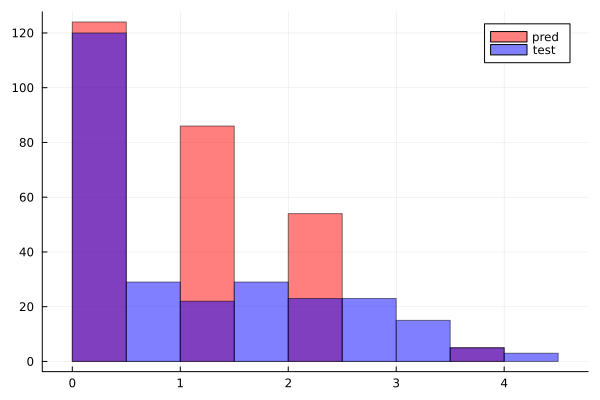

In [10]:
OCTReg = ORT_model(train_valid, test);

# write_json the model
IAI.write_json("OCTReg.json", OCTReg)

# save the predictions
OCTR_pred = IAI.predict(OCTReg, get_features(test))
CSV.write("OCTR_pred.csv", DataFrame(pred = OCTR_pred));

## ORT-H (Optimal Regression Trees with Hyperplane Splitting)

In [11]:
# define ranges for the hyperparameters
max_depth = [3, 4]
minbucket = [2, 5]
;

In [12]:
function ORTH_model(train_valid, test)

    println("Training model...")

    # define the model  
    model_octh = IAI.OptimalTreeRegressor(
        random_seed = 1,
        criterion = :mse,
        hyperplane_config= (sparsity=:all,),
    )

    println("Fitting model...")

    # define the grid
    grid_octh = IAI.GridSearch(
        model_octh,
        max_depth = max_depth,
        minbucket = minbucket,
    )

    println("Fitting model...")

    # fit the model with 5-fold cross validation
    IAI.fit_cv!(grid_octh, get_features(train_valid), Array(get_target(train_valid)), validation_criterion = :mse, n_folds=5)

    println("Predicting...")

    # get the best model
    pred = IAI.predict(grid_octh, get_features(test))

    println("Computing results...")

    # compute the results
    #compute_results(pred, get_target(test))
    transform_and_results(pred, get_target(test))

    # check the prediction value
    check_prediction_value(pred, get_target(test))

    # return the best model
    return IAI.get_learner(grid_octh)
end

ORTH_model (generic function with 1 method)

Training model...
Fitting model...
Fitting model...
Predicting...
Computing results...


Row,mae,mse,rmse,osr2
,Float64,Float64,Float64,Float64
1,4.37597,81.4735,9.02626,0.338284


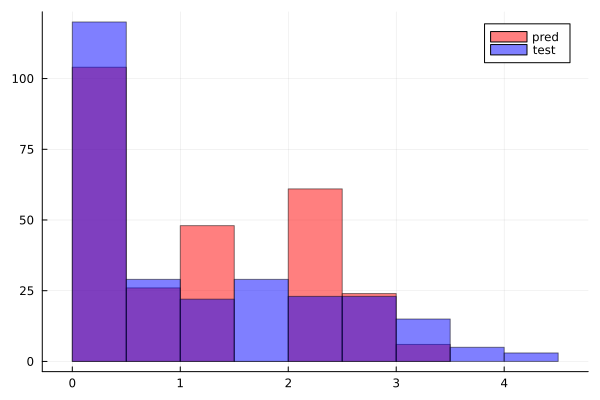

In [13]:
ORTHReg = ORTH_model(train_valid, test);

# write_json the model
IAI.write_json("ORTHReg.json", ORTHReg)

# save the predictions
ORTH_pred = IAI.predict(ORTHReg, get_features(test))
CSV.write("ORTH_pred.csv", DataFrame(pred = ORTH_pred));

In [25]:
# transform and results ORTH_pred
transform_and_results(ORTH_pred, get_target(test))

Row,mae,mse,rmse,osr2
,Float64,Float64,Float64,Float64
1,4.37597,81.4735,9.02626,0.338284


Was taking such a long time to run...
Let's try again

## ORT-L (Optimal Regression Tree with Linear Regression on the leaves)

In [14]:
function ORTL_model(train_valid, test)

    # define the model  
    model_octl = IAI.OptimalTreeRegressor(
        random_seed = 1,
        criterion = :mse,
        max_depth = 4,
        minbucket = 15,
        regression_features = All(),
    )

    println("Training model...")

    # define the grid
    grid_octl = IAI.GridSearch(
        model_octl,
        regression_lambda=[0.01, 0.05, 0.1]
    )

    println("Fitting model...")

    # fit the model with 5-fold cross validation
    IAI.fit_cv!(grid_octl, get_features(train_valid), Array(get_target(train_valid)), validation_criterion = :mse, n_folds=5)

    println("Predicting...")

    # get the best model
    pred = IAI.predict(grid_octl, get_features(test))

    println("Computing results...")

    # compute the results
    #compute_results(pred, get_target(test))
    transform_and_results(pred, get_target(test))

    # check the prediction value
    check_prediction_value(pred, get_target(test))

    # return the best model
    return IAI.get_learner(grid_octl)
end

ORTL_model (generic function with 1 method)

Training model...
Fitting model...


┌ Warning: Numeric instability detected: objective value after iteration did not match the value that was expected so this change was rejected.
│ 
│ Possible causes include:
│ - using linear regression in the leaves with a small `minbucket`
│ - using `:tweedie` criterion with a large number of samples
│ 
│ If none of these apply, please let us know so we can investigate.
└ @ nothing nothing:nothing


Predicting...
Computing results...


Row,mae,mse,rmse,osr2
,Float64,Float64,Float64,Float64
1,0.647486,0.69058,0.831011,0.511711


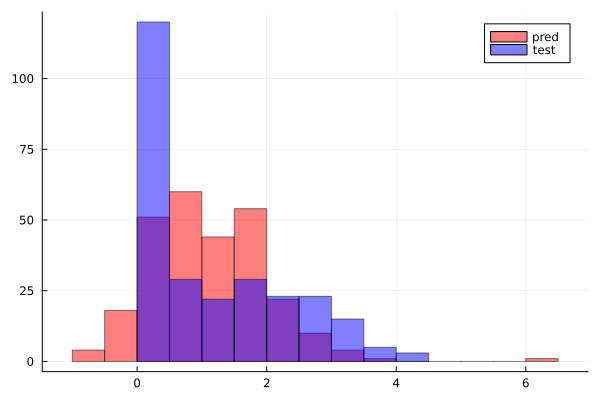

In [15]:
ORTLReg = ORTL_model(train_valid, test);

# write_json the model
IAI.write_json("ORTLReg.json", ORTLReg)

# save the predictions
ORTL_pred = IAI.predict(ORTLReg, get_features(test))
CSV.write("ORTL_pred.csv", DataFrame(pred = ORTL_pred));

In [24]:
# transfrom and results ORTL_pred
transform_and_results(ORTL_pred, get_target(test))

Row,mae,mse,rmse,osr2
,Float64,Float64,Float64,Float64
1,5.84949,884.623,29.7426,-6.18479
